In [ ]:
import tensorflow
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
from numpy.random import seed
from google.colab import drive
import pathlib

print(tensorflow.__version__)

2.9.2


In [ ]:
drive.mount('/content/gdrive', force_remount=True)
directory = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/MGU/alpacas_dataset')
test_directory = '/content/gdrive/MyDrive/Colab_Notebooks/MGU/alpacas_test/*.jpg'

INPUT_SHAPE = (512, 512)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    class_names=['alpaca', 'not_alpaca'],
    image_size=INPUT_SHAPE,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_dataset = image_dataset_from_directory(directory,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=42,
    class_names=['alpaca', 'not_alpaca'],
    image_size=INPUT_SHAPE
)



Mounted at /content/gdrive
Found 316 files belonging to 2 classes.
Using 253 files for training.
Found 316 files belonging to 2 classes.
Using 63 files for validation.


In [ ]:
test_dataset = []

for filename in glob.glob(test_directory):
    img = keras.utils.load_img(filename, target_size=INPUT_SHAPE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tensorflow.expand_dims(img_array, 0)
    test_dataset.append(img_array)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=90,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_batches = train_datagen.flow_from_directory(
    directory,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_batches = train_datagen.flow_from_directory(
    directory,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test1_batches = train_datagen.flow_from_directory(
    directory,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

test2_batches = train_datagen.flow_from_directory(
    test_directory,
    target_size=INPUT_SHAPE,
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

Found 254 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 0 images belonging to 1 classes.


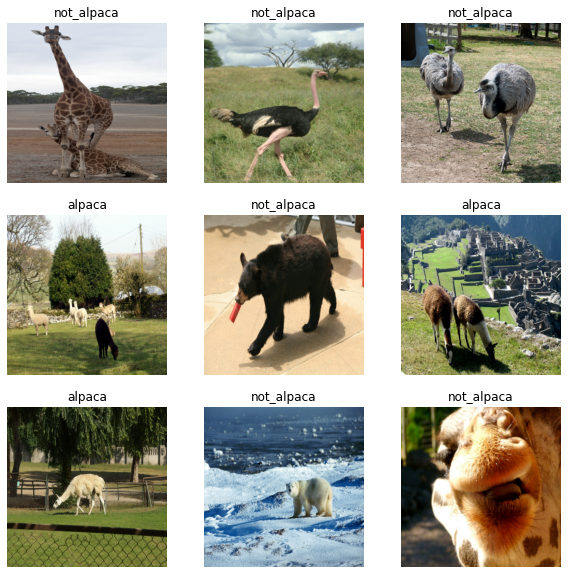

In [ ]:
# images, labels = train_dataset.take(1)
classes = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(classes[int(labels[i])])
      plt.axis("off")

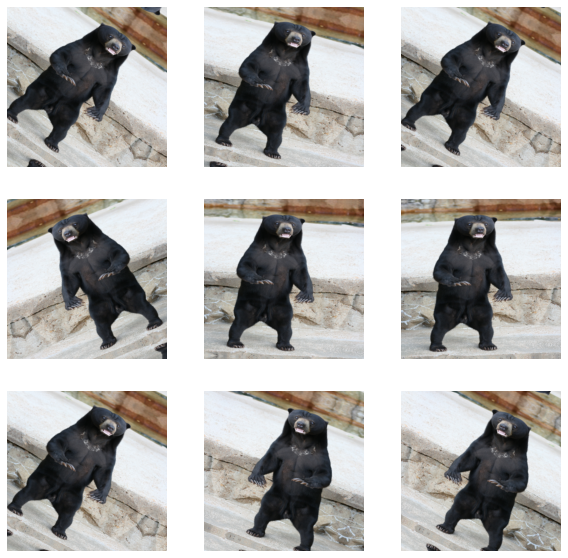

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1)
])


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tensorflow.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

input_shape = INPUT_SHAPE + (3,)

base_model = MobileNetV2(
    input_shape = input_shape,
    include_top = False,
    weights='imagenet'
)
for layer in base_model.layers:
    layer.trainable = False

data_augmentation = None
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1)
])

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(.2)(x)
prediction_layer = keras.layers.Dense(1, activation='sigmoid')

outputs = prediction_layer(x) 
model = keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
8/8 [==============================] - 39s 5s/step - loss: 0.6754 - accuracy: 0.5573 - val_loss: 0.6469 - val_accuracy: 0.6032
Epoch 2/5
8/8 [==============================] - 37s 5s/step - loss: 0.6234 - accuracy: 0.6561 - val_loss: 0.6046 - val_accuracy: 0.7619
Epoch 3/5
8/8 [==============================] - 36s 4s/step - loss: 0.5541 - accuracy: 0.7628 - val_loss: 0.5711 - val_accuracy: 0.7619
Epoch 4/5
8/8 [==============================] - 37s 5s/step - loss: 0.5125 - accuracy: 0.8419 - val_loss: 0.5344 - val_accuracy: 0.7937
Epoch 5/5
8/8 [==============================] - 36s 4s/step - loss: 0.4821 - accuracy: 0.8577 - val_loss: 0.5031 - val_accuracy: 0.8413


1/1 [==============================] - 0s 234ms/step
(0.26, 'alpaca')
1/1 [==============================] - 0s 218ms/step
(0.26, 'alpaca')
1/1 [==============================] - 0s 128ms/step
(0.28, 'alpaca')
1/1 [==============================] - 0s 123ms/step
(0.64, 'not_alpaca')
1/1 [==============================] - 0s 119ms/step
(0.33, 'alpaca')
1/1 [==============================] - 0s 124ms/step
(0.47, 'alpaca')
1/1 [==============================] - 0s 118ms/step
(0.82, 'not_alpaca')
1/1 [==============================] - 0s 123ms/step
(0.48, 'alpaca')
1/1 [==============================] - 0s 123ms/step
(0.58, 'not_alpaca')
1/1 [==============================] - 0s 118ms/step
(0.62, 'not_alpaca')
1/1 [==============================] - 0s 122ms/step
(0.51, 'not_alpaca')


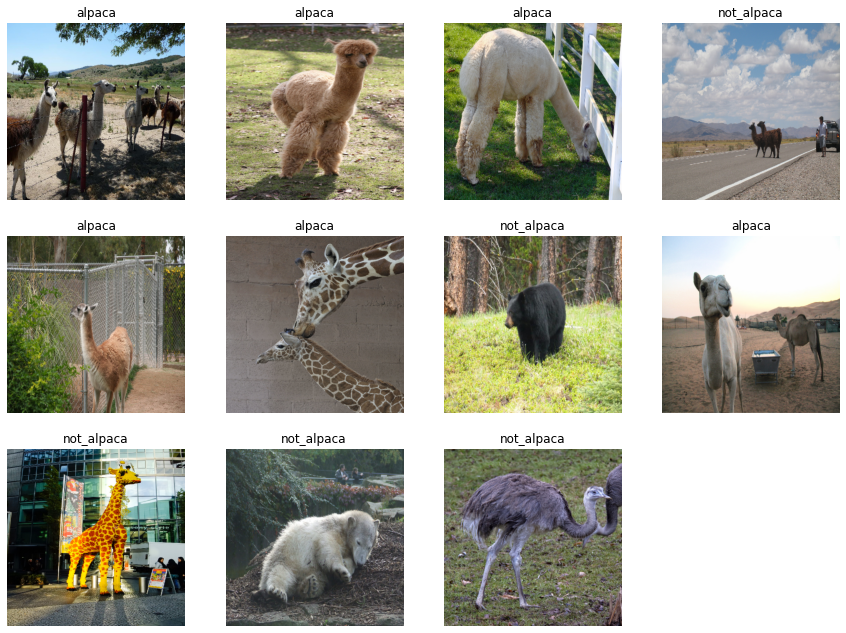

In [ ]:
plt.figure(figsize=(15, 15))
j = 0
for img in test_dataset:
    probability= np.round(model.predict(img).flatten(),2)[0]
    if probability >=0.5: 
        label = classes[1]
    else: 
        label = classes[0]
    ax = plt.subplot(4, 4, j + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img[0].numpy().astype("uint8"))
    print((probability,label))
    j = j + 1

In [ ]:
base_model = MobileNetV2(
    input_shape = input_shape,
    include_top = False,
    weights='imagenet'
)

for layer in base_model.layers[:120]:
    layer.trainable = False

data_augmentation = None
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1)
])

inputs2 = layers.Input(shape=input_shape)
x2 = data_augmentation(inputs2)
x2 = preprocess_input(x2)
x2 = base_model(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(.2)(x2)
prediction_layer2 = keras.layers.Dense(1, activation='sigmoid')

outputs2 = prediction_layer2(x2) 
model2 = keras.Model(inputs2, outputs2)

model2.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model2.fit(train_dataset, validation_data=validation_dataset, epochs=total_epochs)
print(model2.evaluate(validation_dataset, verbose=True))

Epoch 1/10
8/8 [==============================] - 53s 6s/step - loss: 0.6479 - accuracy: 0.6482 - val_loss: 0.6021 - val_accuracy: 0.6349
Epoch 2/10
8/8 [==============================] - 50s 6s/step - loss: 0.3717 - accuracy: 0.8814 - val_loss: 0.5248 - val_accuracy: 0.6984
Epoch 3/10
8/8 [==============================] - 50s 6s/step - loss: 0.2310 - accuracy: 0.9368 - val_loss: 0.4153 - val_accuracy: 0.8413
Epoch 4/10
8/8 [==============================] - 49s 6s/step - loss: 0.1509 - accuracy: 0.9644 - val_loss: 0.3418 - val_accuracy: 0.8730
Epoch 5/10
8/8 [==============================] - 50s 6s/step - loss: 0.0854 - accuracy: 0.9921 - val_loss: 0.2924 - val_accuracy: 0.9206
Epoch 6/10
8/8 [==============================] - 50s 6s/step - loss: 0.0635 - accuracy: 0.9960 - val_loss: 0.2593 - val_accuracy: 0.9524
Epoch 7/10
8/8 [==============================] - 51s 6s/step - loss: 0.0411 - accuracy: 0.9960 - val_loss: 0.2224 - val_accuracy: 0.9683
Epoch 8/10
8/8 [==================

1/1 [==============================] - 1s 1s/step
(0.0, 'alpaca')
1/1 [==============================] - 0s 122ms/step
(0.0, 'alpaca')
1/1 [==============================] - 0s 110ms/step
(0.0, 'alpaca')
1/1 [==============================] - 0s 112ms/step
(0.36, 'alpaca')
1/1 [==============================] - 0s 114ms/step
(0.09, 'alpaca')
1/1 [==============================] - 0s 114ms/step
(0.81, 'not_alpaca')
1/1 [==============================] - 0s 118ms/step
(0.95, 'not_alpaca')
1/1 [==============================] - 0s 120ms/step
(0.84, 'not_alpaca')
1/1 [==============================] - 0s 110ms/step
(0.64, 'not_alpaca')
1/1 [==============================] - 0s 117ms/step
(0.74, 'not_alpaca')
1/1 [==============================] - 0s 122ms/step
(0.66, 'not_alpaca')


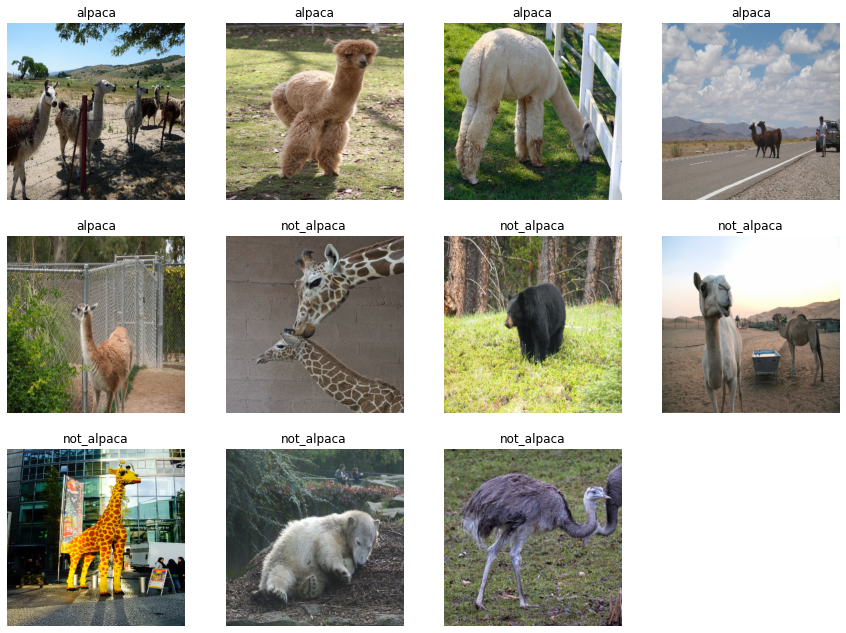

In [ ]:
plt.figure(figsize=(15, 15))
j = 0
for img in test_dataset:
    probability= np.round(model2.predict(img).flatten(),2)[0]
    if probability >=0.5: 
        label = classes[1]
    else: 
        label = classes[0]
    ax = plt.subplot(4, 4, j + 1)
    plt.title("" + label + " - " + probability)
    plt.axis("off")
    plt.imshow(img[0].numpy().astype("uint8"))
    print((probability,label))
    j = j + 1

In [ ]:
model_directory = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/MGU/alpacas_model.h5')

# model2.save(model_directory)

model2 = tensorflow.keras.models.load_model(model_directory)

converter = tensorflow.lite.TFLiteConverter.from_keras_model(model2)

converter.optimizations = [tensorflow.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tensorflow.lite.OpsSet.TFLITE_BUILTINS # enable TensorFlow Lite ops.
]

tflite_model = converter.convert()

with open("/content/gdrive/MyDrive/Colab_Notebooks/MGU/alpacas_model_lite.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
plt.figure(figsize=(15, 15))
j = 0

interpreter = tensorflow.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], test_dataset[5])

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)



[[0.79139924]]


<Figure size 1080x1080 with 0 Axes>